# Plot PyPI download stats

## Download the data

You can download the data using the free Google Cloud BigQuery Sandbox APIs.

1. Set up a BiyQuery Sanbdox account following these instructions: https://cloud.google.com/bigquery/docs/sandbox.
2. Use the online console to run the query (before running the query you can see a preview of the usage in the top right). You have 10 TB of free queries per month. This is the query used shown in the screenshot (documentation here https://packaging.python.org/en/latest/guides/analyzing-pypi-package-downloads/).
```sql
#standardSQL
SELECT
  file.project AS project,
  COUNT(*) AS num_downloads,
  DATE_TRUNC(DATE(timestamp), MONTH) AS `month`
FROM `bigquery-public-data.pypi.file_downloads`
WHERE
  file.project IN ('anndata', 'mudata', 'spatialdata', 'spatialdata-io', 'spatialdata-plot', 'napari-spatialdata', 'scanpy', 'rapids-singlecell', 'muon', 'scvi-tools', 'scirpy', 'squidpy')
  -- Only query the last 5 years of history
  AND DATE(timestamp)
    BETWEEN DATE_TRUNC(DATE_SUB(CURRENT_DATE(), INTERVAL 5 YEAR), MONTH)
    AND CURRENT_DATE()
GROUP BY project, `month`
ORDER BY `month` DESC, project
```

3. Download the data as a CSV file, here called `data.csv`.

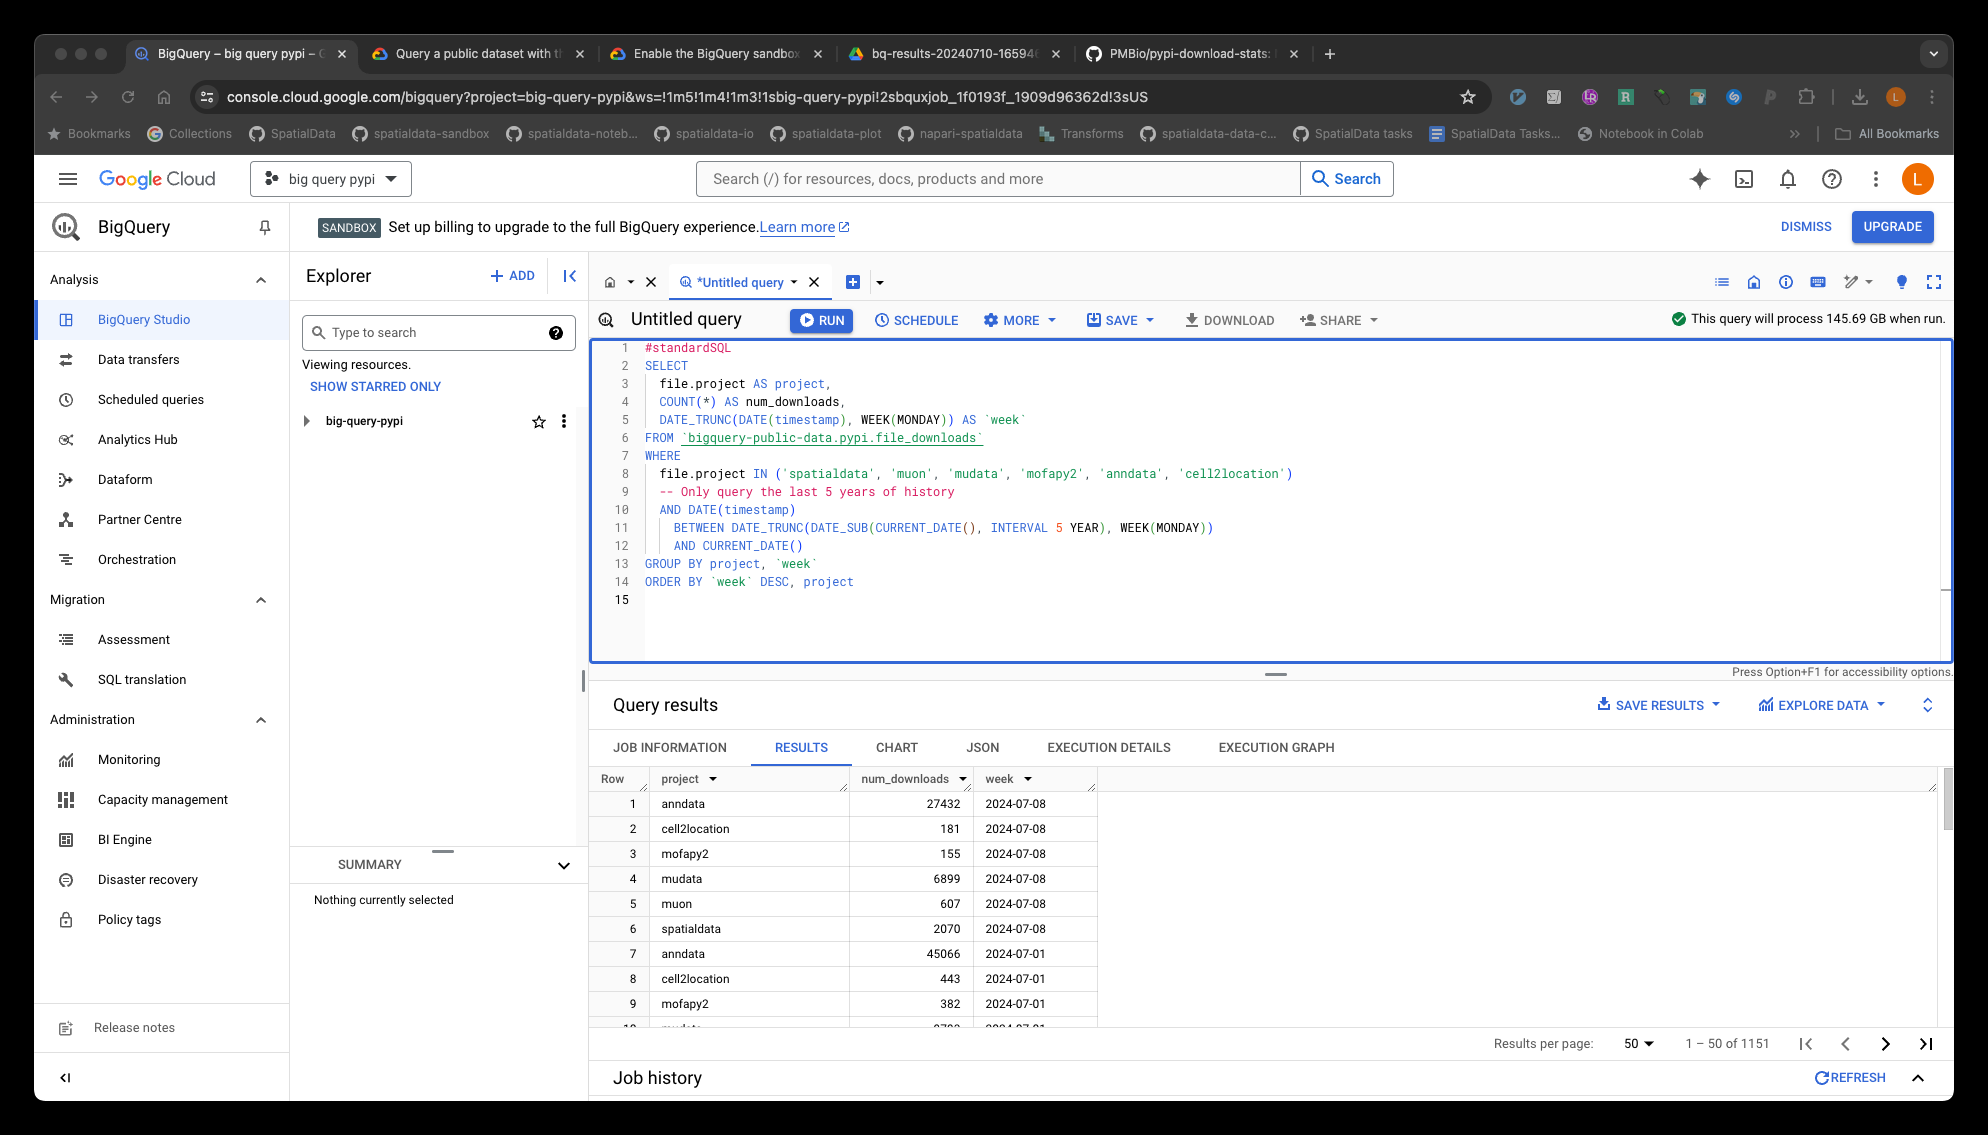

## Plot the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages

# Load the CSV file
file_path = 'data/scverse 2024-09.csv'
data = pd.read_csv(file_path)

data['month'] = pd.to_datetime(data['month'])

In [2]:
data

,project,num_downloads,month
0,anndata,243723,2024-09-01
1,mudata,71818,2024-09-01
2,muon,6746,2024-09-01
3,napari-spatialdata,2911,2024-09-01
4,rapids-singlecell,2171,2024-09-01
...,...,...,...
466,scanpy,6204,2019-11-01
467,anndata,10556,2019-10-01
468,scanpy,6856,2019-10-01
469,anndata,9825,2019-09-01


In [3]:
# remove the current week since the data is incomplete until the week is over)
data = data[data['month'] != data['month'].max()]

# Get the unique projects
projects = data['project'].unique()
projects

array(['anndata', 'mudata', 'muon', 'napari-spatialdata',
       'rapids-singlecell', 'scanpy', 'scirpy', 'scvi-tools',
       'spatialdata', 'spatialdata-io', 'spatialdata-plot', 'squidpy'],
      dtype=object)

In [4]:
import numpy as np

# remove wrong anndata and scanpy data point: they are extreely high for some reasons
# replace it with a simple estimate: average of the 2 data points before and 2 data points after
def simple_correction(project: str) -> float:
    other_months = ['2022-04-01', '2022-05-01', '2022-07-01', '2022-07-01']
    mean = 0
    for month in other_months:
        value = data[(data['project'] == project) & (data['month'] == month)].num_downloads.item()
        mean += value
    return np.floor(mean / len(other_months))

for project in ['anndata', 'scanpy']:
    data.loc[(data['project'] == project) & (data['month'] == '2022-06-01'), 'num_downloads'] = simple_correction(project=project)
# data[(data['project'] == 'anndata') & (data['month'] == '2022-06-01')]
# data = data[~((data['project'] == 'scanpy') & (data['month'] == '2022-06-01'))]

In [5]:
data[(data['project'] == 'anndata') & (data['month'] == '2022-06-01')]

,project,num_downloads,month
298,anndata,42290,2022-06-01


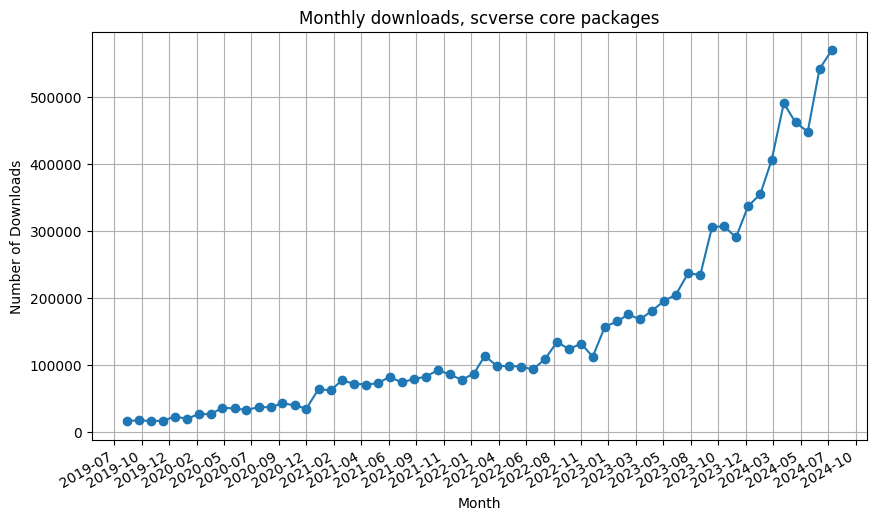

'aggregated_downloads_plots.pdf'

In [6]:
# aggregated
pdf_path = 'aggregated_downloads_plots.pdf'
with PdfPages(pdf_path) as pdf:
    project_data = data.drop('project', axis=1).groupby('month', as_index=False).sum()
    plt.figure(figsize=(10, 6))
    plt.plot(project_data['month'], project_data['num_downloads'], marker='o')
    plt.title(f'Monthly downloads, scverse core packages')
    plt.xlabel('Month')
    plt.ylabel('Number of Downloads')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
    plt.gcf().autofmt_xdate()
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path

/tmp/ipykernel_38610/3296285129.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = pd.to_datetime(data['month'])


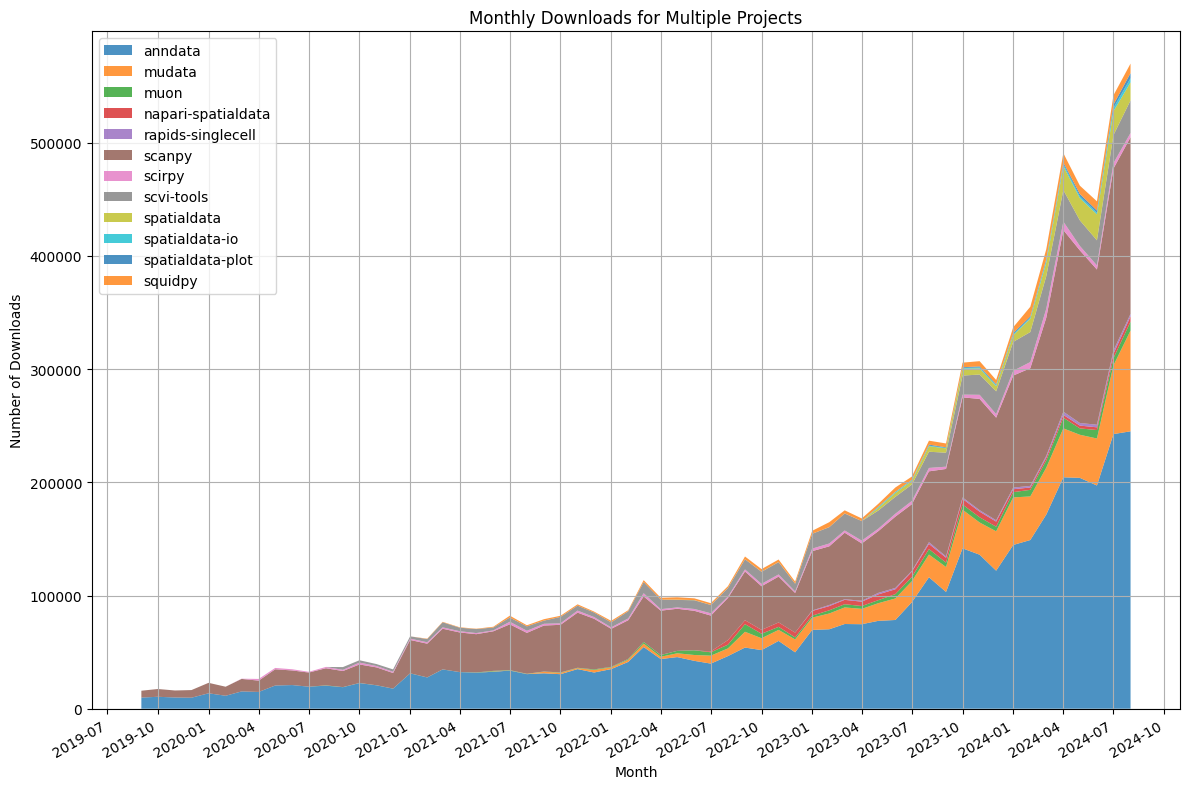

'monthly_downloads_stacked_plot.pdf'

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# Assuming `data` is your DataFrame containing the data
# and `projects` is a list of project names

# Create a PDF with a single plot for all projects
pdf_path = 'monthly_downloads_stacked_plot.pdf'

# Prepare the data for plotting
data['month'] = pd.to_datetime(data['month'])
data = data.sort_values('month')

# Pivot the data to get projects as columns
pivot_df = data.pivot_table(index='month', columns='project', values='num_downloads', fill_value=0)

# Create a stacked area plot
with PdfPages(pdf_path) as pdf:
    plt.figure(figsize=(12, 8))
    
    plt.stackplot(pivot_df.index, pivot_df.T, labels=pivot_df.columns, alpha=0.8)
    
    plt.title('Monthly Downloads for Multiple Projects')
    plt.xlabel('Month')
    plt.ylabel('Number of Downloads')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path


In [8]:
# Create a PDF with plots for each project
pdf_path = 'monthly_downloads_plots.pdf'
with PdfPages(pdf_path) as pdf:
    for project in projects:
        project_data = data[data['project'] == project]
        plt.figure(figsize=(10, 6))
        plt.plot(project_data['month'], project_data['num_downloads'], marker='o')
        plt.title(f'Monthly downloads for {project}')
        plt.xlabel('Month')
        plt.ylabel('Number of Downloads')
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
        plt.gcf().autofmt_xdate()
        pdf.savefig()
        # plt.show()
        plt.close()

pdf_path

'monthly_downloads_plots.pdf'

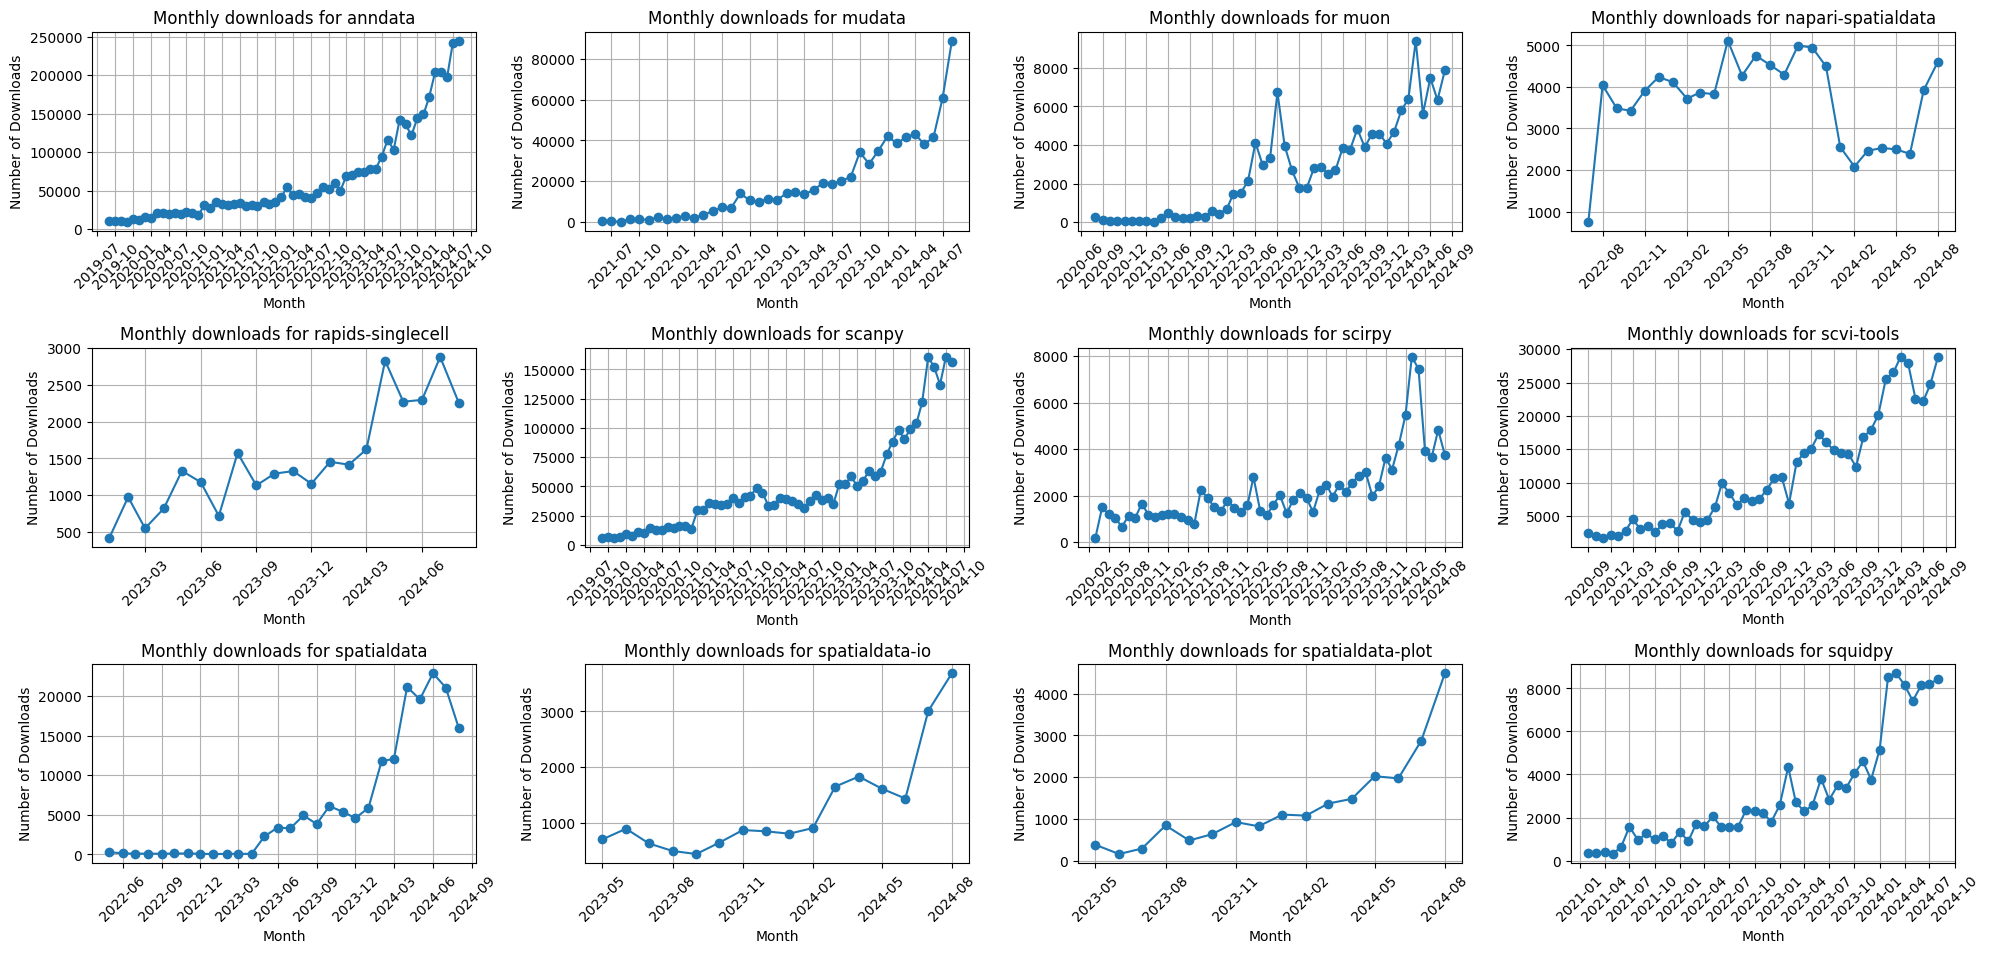

'monthly_downloads_plots.pdf'

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# Assuming `data` is your DataFrame containing the data
# and `projects` is a list of project names

# Create a PDF with a grid of plots for all projects
pdf_path = 'monthly_downloads_plots.pdf'

# Define the grid size (e.g., 2 rows and 3 columns for up to 6 projects)
rows = 4
cols = 4

with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    for i, project in enumerate(projects):
        project_data = data[data['project'] == project]
        ax = axes[i]
        ax.plot(project_data['month'], project_data['num_downloads'], marker='o')
        ax.set_title(f'Monthly downloads for {project}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Downloads')
        ax.grid(True)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path


In [10]:
condenser_ab = {
    'anndata': 'A',
    'mudata': 'A',
    'muon': 'B',
    'napari-spatialdata': 'B',
    'rapids-singlecell': 'B',
    'scanpy': 'B',
    'scirpy': 'B',
    'scvi-tools': 'B',
    'spatialdata': 'A',
    'spatialdata-io': 'B',
    'spatialdata-plot': 'B',
    'squidpy': 'B',
}
replace = {
    'A': 'core data structures',
    'B': 'core analysis methods'
}
condenser_ab = {k: replace[v] for k, v in condenser_ab.items()}

data['project_ab'] = data['project'].apply(lambda x: condenser_ab[x])
data_ab = data.groupby(['project_ab', 'month'], as_index=False).sum()

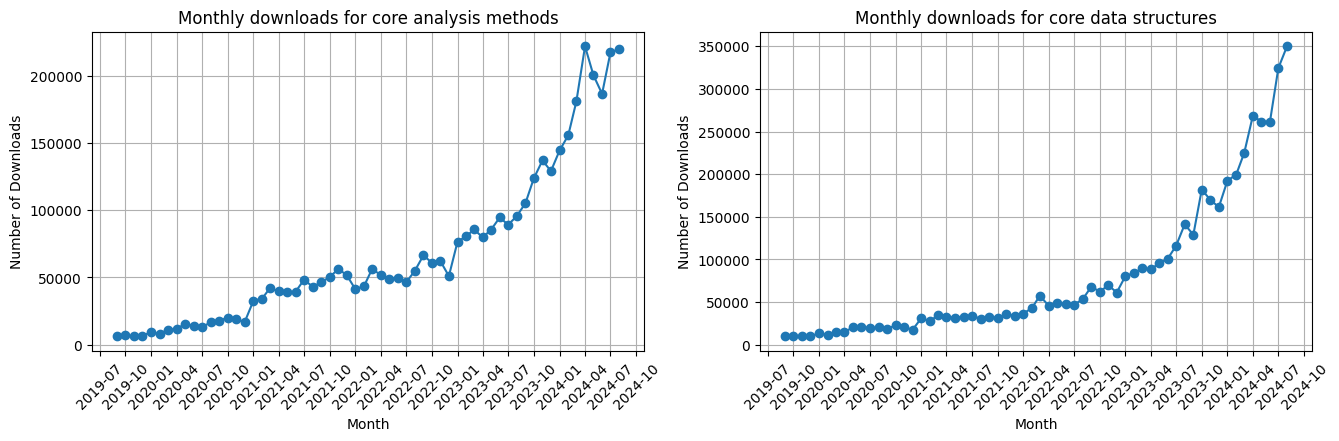

'monthly_downloads_plots.pdf'

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# my_data = data_12345
# my_data['project'] = my_data['project_12345']

my_data = data_ab
my_data['project'] = my_data['project_ab']

projects = my_data['project'].unique()

# Create a PDF with a grid of plots for all projects
pdf_path = 'monthly_downloads_plots.pdf'

# Define the grid size (e.g., 2 rows and 3 columns for up to 6 projects)
rows = 3
cols = 3

with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    for i, project in enumerate(projects):
        project_data = my_data[my_data['project'] == project]
        ax = axes[i]
        ax.plot(project_data['month'], project_data['num_downloads'], marker='o')
        title = f'Monthly downloads for {project}'
        ax.set_title(title)
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Downloads')
        ax.grid(True)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path


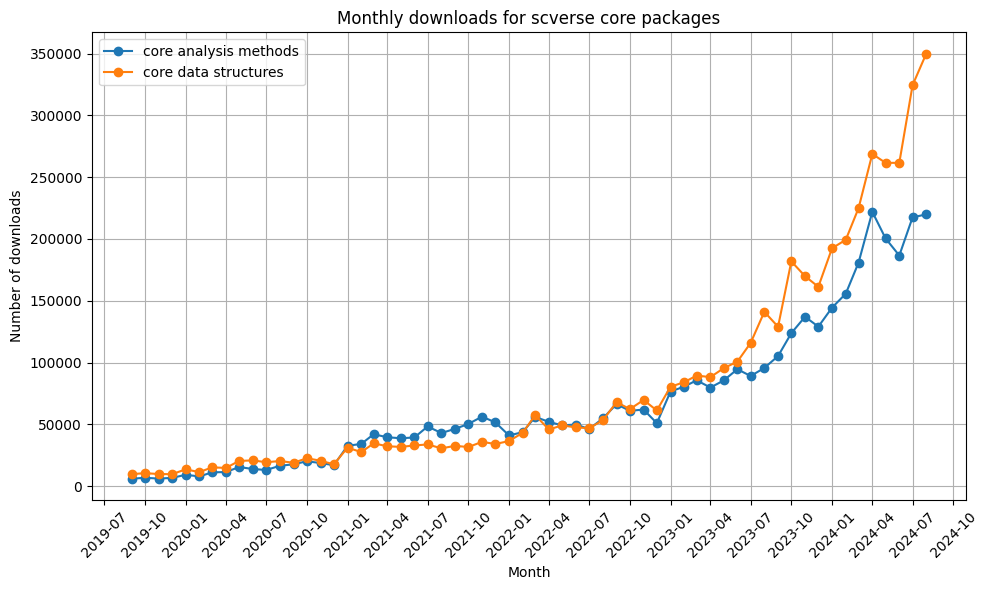

'combined_monthly_downloads_plot.pdf'

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

colors = plt.cm.tab10.colors[:2]

# Assuming my_data_2 is your dataset
my_data_2 = data_ab
my_data_2['project'] = my_data_2['project_ab']

# Get unique projects
projects = my_data_2['project'].unique()

# Create a PDF for the plot
pdf_path = 'combined_monthly_downloads_plot.pdf'

with PdfPages(pdf_path) as pdf:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each project
    for i, project in enumerate(projects):
        project_data = my_data_2[my_data_2['project'] == project]
        ax.plot(project_data['month'], project_data['num_downloads'], marker='o', label=f'{project}', color=colors[i])
    
    # Set the title and labels
    ax.set_title('Monthly downloads for scverse core packages')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of downloads')
    
    # Format the x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Add a grid, legend, and tight layout
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    
    # Save the plot to the PDF
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path
